<a href="https://colab.research.google.com/github/ms1901/CF_Project/blob/main/Analysis/Analysis_CARL_AutomotiveFiles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --upgrade tensorflow

     |████████████████████████████████| 462 kB 5.3 MB/s 


In [ ]:
import numpy as np
import scipy.sparse as sp
import math

import tensorflow as tf
import numpy as np
import sys
from time import time
import os

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(tf.version)

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [ ]:
%cd /content/drive/MyDrive/CF_end_proejct/Automotive

/content/drive/MyDrive/CF_end_proejct/Automotive


In [ ]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


ExtractData

In [ ]:
class Dataset(object):
    "'extract dataset from file'"

    def __init__(self, max_length, path, word_id_path):
        self.word_id_dict = self.load_word_dict(path + word_id_path)
        print("wordId_dict finished")
        
        self.userReview_dict = self.load_reviews(max_length, len(self.word_id_dict), path + "dataPreprocessingUserReviews.out")
        self.itemReview_dict = self.load_reviews(max_length, len(self.word_id_dict), path + "dataPreprocessingItemReviews.out")
        print("load reviews finished")
        
        self.num_users, self.num_items = len(self.userReview_dict), len(self.itemReview_dict)
        
        self.trainMtrx = self.load_ratingFile_as_mtrx(path + "dataPreprocessingTrainInteraction.out")
        self.valRatings = self.load_ratingFile_as_list(path + "dataPreprocessingValInteraction.out")
        self.testRatings = self.load_ratingFile_as_list(path + "dataPreprocessingTestInteraction.out")

    def load_word_dict(self, path):
        wordId_dict = {}

        with open(path, "r") as f:
            line = f.readline().replace("\n", "")
            while line != None and line != "":
                arr = line.split("\t")
                wordId_dict[arr[0]] = int(arr[1])
                line = f.readline().replace("\n", "")

        return wordId_dict

    def load_reviews(self, max_doc_length, padding_word_id, path):
        entity_review_dict = {}

        with open(path, "r") as f:
            line = f.readline().replace("\n", "")
            while line != None and line != "":
                review = []
                arr = line.split("\t")
                entity = int(arr[0])
                word_list = arr[1].split(" ")

                for i in range(len(word_list)):
                    if (word_list[i] == "" or word_list[i] == None or (not self.word_id_dict[word_list[i]] in self.word_id_dict.keys())):
                        continue
                    review.append(self.word_id_dict.get(word_list[i]))
                    if (len(review) >= max_doc_length):
                        break
                if (len(review) < max_doc_length):
                    review = self.padding_word(max_doc_length, padding_word_id, review)
                entity_review_dict[entity] = review
                line = f.readline().replace("\n", "")
        return entity_review_dict

    def padding_word(self, max_size, max_word_idx, review):
        review.extend([max_word_idx]*(max_size - len(review)))
        return review

    def load_ratingFile_as_mtrx(self, file_path):
        mtrx = sp.dok_matrix((self.num_users, self.num_items), dtype=np.float32)
        with open(file_path, "r") as f:
            line = f.readline()
            line = line.strip()
            while line != None and line != "":
                arr = line.split("\t")
                user, item, rating = int(arr[0]), int(arr[1]), float(arr[2])
                if (rating > 0):
                    mtrx[user, item] = rating
                line = f.readline()

        return mtrx

    def load_ratingFile_as_list(self, file_path):
        rateList = []

        with open(file_path, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                user, item = int(arr[0]), int(arr[1])
                rate = float(arr[2])
                rateList.append([user, item, rate])
                line = f.readline()

        return rateList

GetTest

In [ ]:
import math

def get_test_list(batch_size, test_rating, user_reviews, item_reviews):
    user_test_batchs, item_test_batchs, user_input_test_batchs, item_input_test_batchs, rating_input_test_batchs = [], [], [], [], []
    for count in range(int(math.ceil(len(test_rating) / float(batch_size)))):
        user_test, item_test, user_input_test, item_input_test, rating_input_test = [], [], [], [], []
        for idx in range(batch_size):
            index = (count * batch_size + idx)
            if (index >= len(test_rating)):
                break
            rating = test_rating[index]
            user_test.append(rating[0])
            item_test.append(rating[1])
            user_input_test.append(user_reviews.get(rating[0]))
            item_input_test.append(item_reviews.get(rating[1]))
            rating_input_test.append([rating[2]])
        user_test_batchs.append(user_test)
        item_test_batchs.append(item_test)
        user_input_test_batchs.append(user_input_test)
        item_input_test_batchs.append(item_input_test)
        rating_input_test_batchs.append(rating_input_test)
        #print count, len(item_input_test_batchs[count])
    return user_test_batchs, item_test_batchs, user_input_test_batchs, item_input_test_batchs, rating_input_test_batchs

CARL

In [ ]:
def ini_word_embed(num_words, latent_dim):
    word_embeds = np.random.rand(num_words, latent_dim)
    return word_embeds


In [ ]:
def word2vec_word_embed(num_words, latent_dim, path, word_id_dict):
    word2vect_embed_mtrx = np.zeros((num_words, latent_dim))
    with open(path, "r") as f:
        line = f.readline()
        while line != None and line != "":
            arr = line.split("\t")
            row_id = word_id_dict.get(arr[0])
            vect = arr[1].strip().split(" ")
            for i in range(len(vect)):
                word2vect_embed_mtrx[row_id, i] = float(vect[i])
            line = f.readline()

    return word2vect_embed_mtrx

In [ ]:
def get_train_instance(train):
    user_input, item_input, rates = [], [], []

    for (u, i) in train.keys():
        # positive instance
        user_input.append(u)
        item_input.append(i)
        rates.append(train[u,i])
    return user_input, item_input, rates



In [ ]:
def get_train_instance_batch_change(count, batch_size, user_input, item_input, ratings, user_reviews, item_reviews):
    users_batch, items_batch, user_input_batch, item_input_batch, labels_batch = [], [], [], [], []

    for idx in range(batch_size):
        index = (count*batch_size + idx) % len(user_input)
        users_batch.append(user_input[index])
        items_batch.append(item_input[index])
        user_input_batch.append(user_reviews.get(user_input[index]))
        item_input_batch.append(item_reviews.get(item_input[index]))
        labels_batch.append([ratings[index]])

    return users_batch, items_batch, user_input_batch, item_input_batch, labels_batch

In [ ]:
#review.py
def  cnn_model_average(filters, user_reviews_representation_expnd, item_reviews_representation_expnd, W_u, W_i, W_u_1, W_i_1, rand_matrix):
    #convolution layer
    convU = tf.nn.conv2d(user_reviews_representation_expnd, W_u, strides=[1, 1, word_latent_dim, 1], padding='SAME')
    convI = tf.nn.conv2d(item_reviews_representation_expnd, W_i, strides=[1, 1, word_latent_dim, 1], padding='SAME')

    hU = tf.nn.relu(tf.squeeze(convU, 2))
    hI = tf.nn.relu(tf.squeeze(convI, 2))

    # attentive layer
    sec_dim = int(hU.get_shape()[1])
    tmphU = tf.reshape(hU, [-1, filters])
    hU_mul_rand = tf.reshape(tf.matmul(tmphU, rand_matrix), [-1, sec_dim, filters])
    f = tf.matmul(hU_mul_rand, hI, transpose_b=True)
    f = tf.expand_dims(f, -1)
    att1 = tf.tanh(f)

    pool_user = tf.reduce_mean(att1, 2)
    pool_item = tf.reduce_mean(att1, 1)

    user_flat = tf.squeeze(pool_user, -1)
    item_flat = tf.squeeze(pool_item, -1)

    weight_user = tf.nn.softmax(user_flat)
    weight_item = tf.nn.softmax(item_flat)

    weight_user_exp = tf.expand_dims(weight_user, -1)
    weight_item_exp = tf.expand_dims(weight_item, -1)

    hU = tf.expand_dims(hU * weight_user_exp, -1)
    hI = tf.expand_dims(hI * weight_item_exp, -1)

    #abstracting layer
    hU_1 = tf.nn.relu(tf.nn.conv2d(hU, W_u_1, strides=[1, 1, 1, 1], padding='VALID'))
    hI_1 = tf.nn.relu(tf.nn.conv2d(hI, W_i_1, strides=[1, 1, 1, 1], padding='VALID'))

    sec_dim = hU_1.get_shape()[1]

    oU = tf.nn.avg_pool(hU_1, ksize=[1, sec_dim, 1, 1], strides=[1, 1, 1, 1],
        padding='VALID')
    oI = tf.nn.avg_pool(hI_1, ksize=[1, sec_dim, 1, 1], strides=[1, 1, 1, 1],
        padding='VALID')

    att_user = tf.squeeze(oU)
    att_item = tf.squeeze(oI)
    #print "attention", att_user.get_shape(), att_item.get_shape()

    return att_user, att_item

In [ ]:
def eval_model(users, items, users_inputs, items_inputs, dropout_rate, predict_rating, sess, user_batch, item_batch, user_input_batch, item_input_batch, rate_tests, rmses, maes):
    print(sess)
    print("user batch. "+str(user_batch))
    print("item batch "+str(item_batch))
    print("user_input_batch. "+str(user_input_batch))
    print("item_input_batch "+str( item_input_batch))

    print("before session run")
    predicts = sess.run(predict_rating, feed_dict={users: user_batch, items: item_batch, users_inputs: user_input_batch, items_inputs: item_input_batch, dropout_rate:1.0})
    print("after session run")
    #print(predicts)
    row, col = predicts.shape
    for r in range(row):
        rmses.append(pow((predicts[r, 0] - rate_tests[r][0]), 2))
        maes.append(abs((predicts[r, 0] - rate_tests[r][0])))
    print(rmses)
    return rmses, maes


## Just interaction based

In [ ]:
#combination of interaction.py and review.py
def train_model():
    mae_list=[]
    mse_list=[]
    tf.compat.v1.disable_eager_execution()
    #I and R-----
    users = tf.compat.v1.placeholder(tf.int32, shape=[None])
    items = tf.compat.v1.placeholder(tf.int32, shape=[None])
    users_inputs = tf.compat.v1.placeholder(tf.int32, shape=[None, max_doc_length])
    items_inputs = tf.compat.v1.placeholder(tf.int32, shape=[None, max_doc_length])
    ratings = tf.compat.v1.placeholder(tf.float32, shape=[None, 1])
    
    #R-----
    dropout_rate = tf.compat.v1.placeholder(tf.float32)
    
    #I-----
    user_entity_embedding = tf.Variable(tf.random.normal([num_users, latent_dim], mean=0, stddev=0.02), name="user_entity_embeddings")
    item_entity_embedding = tf.Variable(tf.random.normal([num_items, latent_dim], mean=0, stddev=0.02), name="item_entity_embeddings")
    user_entity_embeds = tf.nn.embedding_lookup(user_entity_embedding, users)
    item_entity_embeds = tf.nn.embedding_lookup(item_entity_embedding, items)
    
    #R-----
    user_bias = tf.Variable(tf.random.normal([num_users, 1], mean=0, stddev=0.02), name="user_bias")
    item_bias = tf.Variable(tf.random.normal([num_items, 1], mean=0, stddev=0.02), name="item_bias")
    user_bs = tf.nn.embedding_lookup(user_bias, users)
    item_bs = tf.nn.embedding_lookup(item_bias, items)
    
    text_embedding = tf.Variable(word_embedding_mtrx, dtype=tf.float32, name="review_text_embeds")
    padding_embedding = tf.Variable(np.zeros([1, word_latent_dim]), dtype=tf.float32)
    text_mask = tf.constant([1.0] * text_embedding.get_shape()[0] + [0.0])
    word_embeddings = tf.concat([text_embedding, padding_embedding], 0)
    word_embeddings = word_embeddings * tf.expand_dims(text_mask, -1)
    user_reviews_representation = tf.nn.embedding_lookup(word_embeddings, users_inputs)
    user_reviews_representation_expnd = tf.expand_dims(user_reviews_representation, -1)
    item_reviews_representation = tf.nn.embedding_lookup(word_embeddings, items_inputs)
    item_reviews_representation_expnd = tf.expand_dims(item_reviews_representation, -1)
    
    # CNN layers
    W_u = tf.Variable(tf.random.truncated_normal([window_size, word_latent_dim, 1, num_filters], stddev=0.3), name="review_W_u")
    W_i = tf.Variable(tf.random.truncated_normal([window_size, word_latent_dim, 1, num_filters], stddev=0.3), name="review_W_i")
    W_u_1 = tf.Variable(tf.random.truncated_normal([window_size, num_filters, 1, num_filters], stddev=0.3), name="review_W_u_1")
    W_i_1 = tf.Variable(tf.random.truncated_normal([window_size, num_filters, 1, num_filters], stddev=0.3), name="review_W_i_1")
    # b = tf.Variable(tf.constant(0.1, shape=[self.num_filters]))
    rand_matrix = tf.Variable(tf.random.truncated_normal([num_filters, num_filters], stddev=0.3), name="review_rand_matrix")

    user_embeds, item_embeds = cnn_model_average(num_filters, user_reviews_representation_expnd, item_reviews_representation_expnd, W_u, W_i, W_u_1, W_i_1, rand_matrix)
    
    #shared MLP layer
    W_mlp = tf.Variable(tf.random.normal([num_filters, latent_dim], mean=0, stddev=0.02), name="review_W_mlp")
    W_mlp = tf.nn.dropout(W_mlp, dropout_rate)
    b_mlp = tf.Variable(tf.constant(0.1, shape=[latent_dim]), name="review_b_mlp")

    user_embeds = tf.nn.relu(tf.matmul(user_embeds, W_mlp) + b_mlp)
    item_embeds = tf.nn.relu(tf.matmul(item_embeds, W_mlp) + b_mlp)

    embeds_sum = tf.concat([tf.multiply(user_embeds, item_embeds), user_embeds, item_embeds], 1, name="concat_embed")
    #I
    entity_embeds_sum = tf.concat([tf.multiply(user_entity_embeds, item_entity_embeds), user_entity_embeds, item_entity_embeds],1)

    #FM layer
    #R---
    # w_0 = tf.Variable(tf.zeros(1), name="review_w_0")
    # w_1 = tf.Variable(tf.random.truncated_normal([1, latent_dim * 3], stddev=0.3), name="review_w_1")
    # v = tf.Variable(tf.random.truncated_normal([latent_dim * 3, latent_dim * 3], stddev=0.3), name="review_v")
    
    #I---
    w_entity_0 = tf.Variable(tf.zeros(1), name="entity_w_0")
    w_entity_1 = tf.Variable(tf.random.truncated_normal([1, latent_dim*3], stddev=0.3), name="entity_w_1")
    v_entity = tf.Variable(tf.random.truncated_normal([latent_dim*3, v_dim], stddev=0.3), name="entity_v")
    
    #I---
    J_e_1 = w_entity_0 + tf.matmul(entity_embeds_sum, w_entity_1, transpose_b=True)
    #R---
    # J_1 = w_0 + tf.matmul(embeds_sum, w_1, transpose_b=True)
    
    #I---
    entity_embeds_sum_1 = tf.expand_dims(entity_embeds_sum, -1)
    entity_embeds_sum_2 = tf.expand_dims(entity_embeds_sum, 1)
    #R---
    # embeds_sum_1 = tf.expand_dims(embeds_sum, -1)
    # embeds_sum_2 = tf.expand_dims(embeds_sum, 1)
    
    #I---
    J_e_2 = tf.reduce_sum(tf.reduce_sum(tf.multiply(tf.matmul(entity_embeds_sum_1, entity_embeds_sum_2), tf.matmul(v_entity, v_entity, transpose_b=True)),2), 1, keepdims=True)
    #J_e_3 = tf.trace(tf.multiply(tf.matmul(entity_embeds_sum_1, entity_embeds_sum_2), tf.matmul(v_entity, v_entity, transpose_b=True))) 
    
    #R---
    # J_2 = tf.reduce_sum(tf.reduce_sum(tf.multiply(tf.matmul(embeds_sum_1, embeds_sum_2), tf.matmul(v, v, transpose_b=True)),2), 1, keepdims=True)
    #J_3 = tf.trace(tf.multiply(tf.matmul(embeds_sum_1, embeds_sum_2), tf.matmul(v, v, transpose_b=True)))
    #R---
    # J_total = (J_1 + 0.5 * (J_2))
    
    #I---
    J_e_total = (J_e_1 + 0.5 * (J_e_2))
    
    
    # numerator = J_total + J_e_total
    numerator = J_e_total
    # predict_rating = tf.divide(J_total, numerator) * J_total + tf.divide(J_e_total,numerator) * J_e_total + user_bs + item_bs
    predict_rating = tf.divide(J_e_total,numerator) * J_e_total + user_bs + item_bs 
    loss = tf.reduce_mean(tf.math.squared_difference(predict_rating, ratings))
    loss += lambda_1 * (tf.nn.l2_loss(W_i_1) + tf.nn.l2_loss(W_u_1) + tf.nn.l2_loss(user_entity_embedding) + tf.nn.l2_loss(item_entity_embedding) + tf.nn.l2_loss(W_u) + tf.nn.l2_loss(W_i) + tf.nn.l2_loss(v_entity) + tf.nn.l2_loss(rand_matrix) + tf.nn.l2_loss(user_bs) + tf.nn.l2_loss(item_bs))
    train_step = tf.compat.v1.train.RMSPropOptimizer(learning_rate).minimize(loss)
    saver = tf.compat.v1.train.Saver()
    
    init = tf.compat.v1.global_variables_initializer()
    with tf.compat.v1.Session() as sess:
        sess.run(init)

        for e in range(epochs):
            t = time()
            loss_total = 0.0
            count = 0.0
            
            for i in range(int(math.ceil(len(user_input) / float(batch_size)))):
                user_batch, item_batch, user_input_batch, item_input_batch, rates_batch = get_train_instance_batch_change(i, batch_size,user_input, item_input, rateings, user_reviews,item_reviews)
                _, loss_val, words = sess.run([train_step, loss, word_embeddings], feed_dict={users: user_batch, items: item_batch, users_inputs: user_input_batch, items_inputs: item_input_batch, ratings: rates_batch, dropout_rate:drop_out})
                loss_total += loss_val
                count += 1.0

            t1 = time()            
            #LOOK FROM HERE 
            val_mses, val_maes = [], []
            for i in range(len(user_input_val)):
                #eval_model(users, items, users_inputs, items_inputs, dropout_rate, predict_rating, sess, user_vals[i], item_vals[i], user_input_val[i], item_input_val[i], rating_input_val[i], val_mses, val_maes)
                #predicts = sess.run(predict_rating, feed_dict={users: user_batch, items: item_batch, users_inputs: user_input_batch, items_inputs: item_input_batch, dropout_rate:1.0})
                predicts = sess.run(predict_rating, feed_dict={users: user_vals[i], items: item_vals[i], users_inputs: user_input_val[i], items_inputs: item_input_val[i], ratings: rating_input_val[i], dropout_rate: drop_out})
                #print(predicts)
                row, col = predicts.shape
                for r in range(row):
                    val_mses.append(pow((predicts[r, 0] - rating_input_val[i][r][0]), 2))
                    val_maes.append(abs((predicts[r, 0] - rating_input_val[i][r][0])))
            val_mse = np.array(val_mses).mean()            
            t2 = time()            
            mses, maes = [], []
            for i in range(len(user_input_test)):
                #eval_model(users, items, users_inputs, items_inputs, dropout_rate, predict_rating, sess, user_tests[i], item_tests[i], user_input_test[i], item_input_test[i], rating_input_test[i], mses, maes)
                predicts_test = sess.run(predict_rating, feed_dict={users: user_tests[i], items: item_tests[i], users_inputs: user_input_test[i], items_inputs: item_input_test[i], ratings: rating_input_test[i], dropout_rate: drop_out})
                #print(predicts)
                row, col = predicts_test.shape
                for r in range(row):
                    mses.append(pow((predicts_test[r, 0] - rating_input_test[i][r][0]), 2))
                    maes.append(abs((predicts_test[r, 0] - rating_input_test[i][r][0])))
                    
            mse = np.array(mses).mean()
            mae = np.array(maes).mean()
            t3 = time()
            mae_list.append(mae)
            mse_list.append(mse)
            print("epoch%d train time: %.3fs test time: %.3f  loss = %.3f val_mse = %.3f mse = %.3f mae = %.3f"%(e, (t1 - t), (t3 - t2), loss_total/count, val_mse, mse, mae))
        
        avg_mae=sum(mae_list) / len(mae_list)
        avg_mse=sum(mse_list)/len(mse_list)
        avg_mae_list.append(avg_mae)
        avg_mse_list.append(avg_mse)
        print("MAE "+str(avg_mae))
        print("MSE "+str(avg_mse))

In [ ]:
if __name__ == "__main__":
    print(sys.path[0])
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    word_latent_dim = 300
    latent_dim = 15
    max_doc_length = 300
    num_filters = 50
    window_size = 3
    v_dim = 50
    learning_rate = 0.001
    lambda_1 = 0.05 #normally we set from [0.05, 0.01, 0.005, 0.001]
    drop_out = 0.8
    batch_size = 200
    epochs = 240
    avg_mae_list = []
    avg_mse_list = []
    
    # loading data
    firTime = time()
    dataSet = Dataset(max_doc_length, sys.path[0], "dataPreprocessingWordDict.out")
    word_dict, user_reviews, item_reviews, train, valRatings, testRatings = dataSet.word_id_dict, dataSet.userReview_dict, dataSet.itemReview_dict, dataSet.trainMtrx, dataSet.valRatings, dataSet.testRatings
    secTime = time()

    num_users, num_items = train.shape
    print("load data: %.3fs" % (secTime - firTime))
    print(num_users, num_items)
    print(latent_dim)

    #load word embeddings
    word_embedding_mtrx = ini_word_embed(len(word_dict), word_latent_dim)
    # word_embedding_mtrx = word2vec_word_embed(len(word_dict), word_latent_dim,
    #                                           "Directory of pretrained WordEmbedding.out",
    #                                           word_dict)

    print( "shape", word_embedding_mtrx.shape)

    # get train instances
    user_input, item_input, rateings = get_train_instance(train)
    print (len(user_input), len(item_input), len(rateings))

    # get test/val instances
    user_vals, item_vals, user_input_val, item_input_val, rating_input_val = get_test_list(200, valRatings, user_reviews, item_reviews)
    user_tests, item_tests, user_input_test, item_input_test, rating_input_test = get_test_list(200, testRatings, user_reviews, item_reviews)

    #train & eval model
    train_model()


wordId_dict finished
load reviews finished
load data: 4.373s
2928 1835
15
shape (18131, 300)
16326 16326 16326
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch0 train time: 3.565s test time: 0.177  loss = 207.310 val_mse = 19.616 mse = 19.941 mae = 4.369
epoch1 train time: 1.046s test time: 0.180  loss = 154.172 val_mse = 18.113 mse = 18.474 mae = 4.196
epoch2 train time: 1.061s test time: 0.168  loss = 92.014 val_mse = 15.944 mse = 16.388 mae = 3.928
epoch3 train time: 1.039s test time: 0.190  loss = 52.357 val_mse = 12.229 mse = 12.866 mae = 3.346
epoch4 train time: 1.061s test time: 0.176  loss = 28.639 val_mse = 8.704 mse = 9.539 mae = 2.687
epoch5 train time: 1.031s test time: 0.168  loss = 16.148 val_mse = 6.385 mse = 7.364 mae = 2.253
epoch6 train time: 1.042s test time: 0.166  loss = 10.472 val_mse = 4.843 mse = 5.926 mae = 1.970
epoch7 train time: 1.012s test time: 0.176  loss = 8.289 val_mse = 3.906 m

## Just review based

In [ ]:
#combination of interaction.py and review.py
def train_model():
    mae_list=[]
    mse_list=[]
    tf.compat.v1.disable_eager_execution()
    #I and R-----
    users = tf.compat.v1.placeholder(tf.int32, shape=[None])
    items = tf.compat.v1.placeholder(tf.int32, shape=[None])
    users_inputs = tf.compat.v1.placeholder(tf.int32, shape=[None, max_doc_length])
    items_inputs = tf.compat.v1.placeholder(tf.int32, shape=[None, max_doc_length])
    ratings = tf.compat.v1.placeholder(tf.float32, shape=[None, 1])
    
    #R-----
    dropout_rate = tf.compat.v1.placeholder(tf.float32)
    
    #I-----
    # user_entity_embedding = tf.Variable(tf.random.normal([num_users, latent_dim], mean=0, stddev=0.02), name="user_entity_embeddings")
    # item_entity_embedding = tf.Variable(tf.random.normal([num_items, latent_dim], mean=0, stddev=0.02), name="item_entity_embeddings")
    # user_entity_embeds = tf.nn.embedding_lookup(user_entity_embedding, users)
    # item_entity_embeds = tf.nn.embedding_lookup(item_entity_embedding, items)
    
    #R-----
    user_bias = tf.Variable(tf.random.normal([num_users, 1], mean=0, stddev=0.02), name="user_bias")
    item_bias = tf.Variable(tf.random.normal([num_items, 1], mean=0, stddev=0.02), name="item_bias")
    user_bs = tf.nn.embedding_lookup(user_bias, users)
    item_bs = tf.nn.embedding_lookup(item_bias, items)
    
    text_embedding = tf.Variable(word_embedding_mtrx, dtype=tf.float32, name="review_text_embeds")
    padding_embedding = tf.Variable(np.zeros([1, word_latent_dim]), dtype=tf.float32)
    text_mask = tf.constant([1.0] * text_embedding.get_shape()[0] + [0.0])
    word_embeddings = tf.concat([text_embedding, padding_embedding], 0)
    word_embeddings = word_embeddings * tf.expand_dims(text_mask, -1)
    user_reviews_representation = tf.nn.embedding_lookup(word_embeddings, users_inputs)
    user_reviews_representation_expnd = tf.expand_dims(user_reviews_representation, -1)
    item_reviews_representation = tf.nn.embedding_lookup(word_embeddings, items_inputs)
    item_reviews_representation_expnd = tf.expand_dims(item_reviews_representation, -1)
    
    # CNN layers
    W_u = tf.Variable(tf.random.truncated_normal([window_size, word_latent_dim, 1, num_filters], stddev=0.3), name="review_W_u")
    W_i = tf.Variable(tf.random.truncated_normal([window_size, word_latent_dim, 1, num_filters], stddev=0.3), name="review_W_i")
    W_u_1 = tf.Variable(tf.random.truncated_normal([window_size, num_filters, 1, num_filters], stddev=0.3), name="review_W_u_1")
    W_i_1 = tf.Variable(tf.random.truncated_normal([window_size, num_filters, 1, num_filters], stddev=0.3), name="review_W_i_1")
    # b = tf.Variable(tf.constant(0.1, shape=[self.num_filters]))
    rand_matrix = tf.Variable(tf.random.truncated_normal([num_filters, num_filters], stddev=0.3), name="review_rand_matrix")

    user_embeds, item_embeds = cnn_model_average(num_filters, user_reviews_representation_expnd, item_reviews_representation_expnd, W_u, W_i, W_u_1, W_i_1, rand_matrix)
    
    #shared MLP layer
    W_mlp = tf.Variable(tf.random.normal([num_filters, latent_dim], mean=0, stddev=0.02), name="review_W_mlp")
    W_mlp = tf.nn.dropout(W_mlp, dropout_rate)
    b_mlp = tf.Variable(tf.constant(0.1, shape=[latent_dim]), name="review_b_mlp")

    user_embeds = tf.nn.relu(tf.matmul(user_embeds, W_mlp) + b_mlp)
    item_embeds = tf.nn.relu(tf.matmul(item_embeds, W_mlp) + b_mlp)

    embeds_sum = tf.concat([tf.multiply(user_embeds, item_embeds), user_embeds, item_embeds], 1, name="concat_embed")
    #I
    # entity_embeds_sum = tf.concat([tf.multiply(user_entity_embeds, item_entity_embeds), user_entity_embeds, item_entity_embeds],1)

    #FM layer
    #R---
    w_0 = tf.Variable(tf.zeros(1), name="review_w_0")
    w_1 = tf.Variable(tf.random.truncated_normal([1, latent_dim * 3], stddev=0.3), name="review_w_1")
    v = tf.Variable(tf.random.truncated_normal([latent_dim * 3, latent_dim * 3], stddev=0.3), name="review_v")
    
    #I---
    # w_entity_0 = tf.Variable(tf.zeros(1), name="entity_w_0")
    # w_entity_1 = tf.Variable(tf.random.truncated_normal([1, latent_dim*3], stddev=0.3), name="entity_w_1")
    # v_entity = tf.Variable(tf.random.truncated_normal([latent_dim*3, v_dim], stddev=0.3), name="entity_v")
    
    #I---
    # J_e_1 = w_entity_0 + tf.matmul(entity_embeds_sum, w_entity_1, transpose_b=True)
    #R---
    J_1 = w_0 + tf.matmul(embeds_sum, w_1, transpose_b=True)
    
    #I---
    # entity_embeds_sum_1 = tf.expand_dims(entity_embeds_sum, -1)
    # entity_embeds_sum_2 = tf.expand_dims(entity_embeds_sum, 1)
    #R---
    embeds_sum_1 = tf.expand_dims(embeds_sum, -1)
    embeds_sum_2 = tf.expand_dims(embeds_sum, 1)
    
    #I---
    # J_e_2 = tf.reduce_sum(tf.reduce_sum(tf.multiply(tf.matmul(entity_embeds_sum_1, entity_embeds_sum_2), tf.matmul(v_entity, v_entity, transpose_b=True)),2), 1, keepdims=True)
    #J_e_3 = tf.trace(tf.multiply(tf.matmul(entity_embeds_sum_1, entity_embeds_sum_2), tf.matmul(v_entity, v_entity, transpose_b=True))) 
    
    #R---
    J_2 = tf.reduce_sum(tf.reduce_sum(tf.multiply(tf.matmul(embeds_sum_1, embeds_sum_2), tf.matmul(v, v, transpose_b=True)),2), 1, keepdims=True)
    #J_3 = tf.trace(tf.multiply(tf.matmul(embeds_sum_1, embeds_sum_2), tf.matmul(v, v, transpose_b=True)))
    #R---
    J_total = (J_1 + 0.5 * (J_2))
    
    #I---
    # J_e_total = (J_e_1 + 0.5 * (J_e_2))
    
    
    # numerator = J_total + J_e_total
    numerator = J_total
    # predict_rating = tf.divide(J_total, numerator) * J_total + tf.divide(J_e_total,numerator) * J_e_total + user_bs + item_bs 
    predict_rating = tf.divide(J_total, numerator) * J_total + user_bs + item_bs
    loss = tf.reduce_mean(tf.math.squared_difference(predict_rating, ratings))
    loss += lambda_1 * (tf.nn.l2_loss(W_i_1) + tf.nn.l2_loss(W_u_1) + tf.nn.l2_loss(W_u) + tf.nn.l2_loss(W_i) + tf.nn.l2_loss(v) + tf.nn.l2_loss(rand_matrix) + tf.nn.l2_loss(user_bs) + tf.nn.l2_loss(item_bs))
    
    train_step = tf.compat.v1.train.RMSPropOptimizer(learning_rate).minimize(loss)
    saver = tf.compat.v1.train.Saver()
    
    init = tf.compat.v1.global_variables_initializer()
    with tf.compat.v1.Session() as sess:
        sess.run(init)

        for e in range(epochs):
            t = time()
            loss_total = 0.0
            count = 0.0
            
            for i in range(int(math.ceil(len(user_input) / float(batch_size)))):
                user_batch, item_batch, user_input_batch, item_input_batch, rates_batch = get_train_instance_batch_change(i, batch_size,user_input, item_input, rateings, user_reviews,item_reviews)
                _, loss_val, words = sess.run([train_step, loss, word_embeddings], feed_dict={users: user_batch, items: item_batch, users_inputs: user_input_batch, items_inputs: item_input_batch, ratings: rates_batch, dropout_rate:drop_out})
                loss_total += loss_val
                count += 1.0

            t1 = time()            
            #LOOK FROM HERE 
            val_mses, val_maes = [], []
            for i in range(len(user_input_val)):
                #eval_model(users, items, users_inputs, items_inputs, dropout_rate, predict_rating, sess, user_vals[i], item_vals[i], user_input_val[i], item_input_val[i], rating_input_val[i], val_mses, val_maes)
                #predicts = sess.run(predict_rating, feed_dict={users: user_batch, items: item_batch, users_inputs: user_input_batch, items_inputs: item_input_batch, dropout_rate:1.0})
                predicts = sess.run(predict_rating, feed_dict={users: user_vals[i], items: item_vals[i], users_inputs: user_input_val[i], items_inputs: item_input_val[i], ratings: rating_input_val[i], dropout_rate: drop_out})
                #print(predicts)
                row, col = predicts.shape
                for r in range(row):
                    val_mses.append(pow((predicts[r, 0] - rating_input_val[i][r][0]), 2))
                    val_maes.append(abs((predicts[r, 0] - rating_input_val[i][r][0])))
            val_mse = np.array(val_mses).mean()            
            t2 = time()            
            mses, maes = [], []
            for i in range(len(user_input_test)):
                #eval_model(users, items, users_inputs, items_inputs, dropout_rate, predict_rating, sess, user_tests[i], item_tests[i], user_input_test[i], item_input_test[i], rating_input_test[i], mses, maes)
                predicts_test = sess.run(predict_rating, feed_dict={users: user_tests[i], items: item_tests[i], users_inputs: user_input_test[i], items_inputs: item_input_test[i], ratings: rating_input_test[i], dropout_rate: drop_out})
                #print(predicts)
                row, col = predicts_test.shape
                for r in range(row):
                    mses.append(pow((predicts_test[r, 0] - rating_input_test[i][r][0]), 2))
                    maes.append(abs((predicts_test[r, 0] - rating_input_test[i][r][0])))
                    
            mse = np.array(mses).mean()
            mae = np.array(maes).mean()
            t3 = time()
            mae_list.append(mae)
            mse_list.append(mse)
            print("epoch%d train time: %.3fs test time: %.3f  loss = %.3f val_mse = %.3f mse = %.3f mae = %.3f"%(e, (t1 - t), (t3 - t2), loss_total/count, val_mse, mse, mae))
        
        avg_mae=sum(mae_list) / len(mae_list)
        avg_mse=sum(mse_list)/len(mse_list)
        avg_mae_list.append(avg_mae)
        avg_mse_list.append(avg_mse)
        print("MAE "+str(avg_mae))
        print("MSE "+str(avg_mse))

In [ ]:
if __name__ == "__main__":
    print(sys.path[0])
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    word_latent_dim = 300
    latent_dim = 15
    max_doc_length = 300
    num_filters = 50
    window_size = 3
    v_dim = 50
    learning_rate = 0.001
    lambda_1 = 0.05 #normally we set from [0.05, 0.01, 0.005, 0.001]
    drop_out = 0.8
    batch_size = 200
    epochs = 240
    avg_mae_list = []
    avg_mse_list = []
    
    # loading data
    firTime = time()
    dataSet = Dataset(max_doc_length, sys.path[0], "dataPreprocessingWordDict.out")
    word_dict, user_reviews, item_reviews, train, valRatings, testRatings = dataSet.word_id_dict, dataSet.userReview_dict, dataSet.itemReview_dict, dataSet.trainMtrx, dataSet.valRatings, dataSet.testRatings
    secTime = time()

    num_users, num_items = train.shape
    print("load data: %.3fs" % (secTime - firTime))
    print(num_users, num_items)
    print(latent_dim)

    #load word embeddings
    word_embedding_mtrx = ini_word_embed(len(word_dict), word_latent_dim)
    # word_embedding_mtrx = word2vec_word_embed(len(word_dict), word_latent_dim,
    #                                           "Directory of pretrained WordEmbedding.out",
    #                                           word_dict)

    print( "shape", word_embedding_mtrx.shape)

    # get train instances
    user_input, item_input, rateings = get_train_instance(train)
    print (len(user_input), len(item_input), len(rateings))

    # get test/val instances
    user_vals, item_vals, user_input_val, item_input_val, rating_input_val = get_test_list(200, valRatings, user_reviews, item_reviews)
    user_tests, item_tests, user_input_test, item_input_test, rating_input_test = get_test_list(200, testRatings, user_reviews, item_reviews)

    #train & eval model
    train_model()


wordId_dict finished
load reviews finished
load data: 1.548s
2928 1835
15
shape (18131, 300)
16326 16326 16326
epoch0 train time: 4.389s test time: 0.474  loss = 193.088 val_mse = 0.890 mse = 0.887 mae = 0.772
epoch1 train time: 4.055s test time: 0.462  loss = 134.663 val_mse = 0.876 mse = 0.868 mae = 0.749
epoch2 train time: 4.053s test time: 0.472  loss = 74.897 val_mse = 0.875 mse = 0.867 mae = 0.749
epoch3 train time: 4.064s test time: 0.470  loss = 37.898 val_mse = 0.874 mse = 0.866 mae = 0.748
epoch4 train time: 4.078s test time: 0.462  loss = 17.161 val_mse = 0.873 mse = 0.866 mae = 0.748
epoch5 train time: 4.069s test time: 0.474  loss = 6.864 val_mse = 0.871 mse = 0.865 mae = 0.747
epoch6 train time: 4.081s test time: 0.468  loss = 2.626 val_mse = 0.870 mse = 0.864 mae = 0.746
epoch7 train time: 4.080s test time: 0.466  loss = 1.379 val_mse = 0.868 mse = 0.863 mae = 0.745
epoch8 train time: 4.084s test time: 0.471  loss = 1.176 val_mse = 0.867 mse = 0.862 mae = 0.744
epoch9 t

CARL

In [ ]:
#combination of interaction.py and review.py
def train_model():
    mae_list=[]
    mse_list=[]
    tf.compat.v1.disable_eager_execution()
    #I and R-----
    users = tf.compat.v1.placeholder(tf.int32, shape=[None])
    items = tf.compat.v1.placeholder(tf.int32, shape=[None])
    users_inputs = tf.compat.v1.placeholder(tf.int32, shape=[None, max_doc_length])
    items_inputs = tf.compat.v1.placeholder(tf.int32, shape=[None, max_doc_length])
    ratings = tf.compat.v1.placeholder(tf.float32, shape=[None, 1])
    
    #R-----
    dropout_rate = tf.compat.v1.placeholder(tf.float32)
    
    #I-----
    user_entity_embedding = tf.Variable(tf.random.normal([num_users, latent_dim], mean=0, stddev=0.02), name="user_entity_embeddings")
    item_entity_embedding = tf.Variable(tf.random.normal([num_items, latent_dim], mean=0, stddev=0.02), name="item_entity_embeddings")
    user_entity_embeds = tf.nn.embedding_lookup(user_entity_embedding, users)
    item_entity_embeds = tf.nn.embedding_lookup(item_entity_embedding, items)
    
    #R-----
    user_bias = tf.Variable(tf.random.normal([num_users, 1], mean=0, stddev=0.02), name="user_bias")
    item_bias = tf.Variable(tf.random.normal([num_items, 1], mean=0, stddev=0.02), name="item_bias")
    user_bs = tf.nn.embedding_lookup(user_bias, users)
    item_bs = tf.nn.embedding_lookup(item_bias, items)
    
    text_embedding = tf.Variable(word_embedding_mtrx, dtype=tf.float32, name="review_text_embeds")
    padding_embedding = tf.Variable(np.zeros([1, word_latent_dim]), dtype=tf.float32)
    text_mask = tf.constant([1.0] * text_embedding.get_shape()[0] + [0.0])
    word_embeddings = tf.concat([text_embedding, padding_embedding], 0)
    word_embeddings = word_embeddings * tf.expand_dims(text_mask, -1)
    user_reviews_representation = tf.nn.embedding_lookup(word_embeddings, users_inputs)
    user_reviews_representation_expnd = tf.expand_dims(user_reviews_representation, -1)
    item_reviews_representation = tf.nn.embedding_lookup(word_embeddings, items_inputs)
    item_reviews_representation_expnd = tf.expand_dims(item_reviews_representation, -1)
    
    # CNN layers
    W_u = tf.Variable(tf.random.truncated_normal([window_size, word_latent_dim, 1, num_filters], stddev=0.3), name="review_W_u")
    W_i = tf.Variable(tf.random.truncated_normal([window_size, word_latent_dim, 1, num_filters], stddev=0.3), name="review_W_i")
    W_u_1 = tf.Variable(tf.random.truncated_normal([window_size, num_filters, 1, num_filters], stddev=0.3), name="review_W_u_1")
    W_i_1 = tf.Variable(tf.random.truncated_normal([window_size, num_filters, 1, num_filters], stddev=0.3), name="review_W_i_1")
    # b = tf.Variable(tf.constant(0.1, shape=[self.num_filters]))
    rand_matrix = tf.Variable(tf.random.truncated_normal([num_filters, num_filters], stddev=0.3), name="review_rand_matrix")

    user_embeds, item_embeds = cnn_model_average(num_filters, user_reviews_representation_expnd, item_reviews_representation_expnd, W_u, W_i, W_u_1, W_i_1, rand_matrix)
    
    #shared MLP layer
    W_mlp = tf.Variable(tf.random.normal([num_filters, latent_dim], mean=0, stddev=0.02), name="review_W_mlp")
    W_mlp = tf.nn.dropout(W_mlp, dropout_rate)
    b_mlp = tf.Variable(tf.constant(0.1, shape=[latent_dim]), name="review_b_mlp")

    user_embeds = tf.nn.relu(tf.matmul(user_embeds, W_mlp) + b_mlp)
    item_embeds = tf.nn.relu(tf.matmul(item_embeds, W_mlp) + b_mlp)

    embeds_sum = tf.concat([tf.multiply(user_embeds, item_embeds), user_embeds, item_embeds], 1, name="concat_embed")
    #I
    entity_embeds_sum = tf.concat([tf.multiply(user_entity_embeds, item_entity_embeds), user_entity_embeds, item_entity_embeds],1)

    #FM layer
    #R---
    w_0 = tf.Variable(tf.zeros(1), name="review_w_0")
    w_1 = tf.Variable(tf.random.truncated_normal([1, latent_dim * 3], stddev=0.3), name="review_w_1")
    v = tf.Variable(tf.random.truncated_normal([latent_dim * 3, latent_dim * 3], stddev=0.3), name="review_v")
    
    #I---
    w_entity_0 = tf.Variable(tf.zeros(1), name="entity_w_0")
    w_entity_1 = tf.Variable(tf.random.truncated_normal([1, latent_dim*3], stddev=0.3), name="entity_w_1")
    v_entity = tf.Variable(tf.random.truncated_normal([latent_dim*3, v_dim], stddev=0.3), name="entity_v")
    
    #I---
    J_e_1 = w_entity_0 + tf.matmul(entity_embeds_sum, w_entity_1, transpose_b=True)
    #R---
    J_1 = w_0 + tf.matmul(embeds_sum, w_1, transpose_b=True)
    
    #I---
    entity_embeds_sum_1 = tf.expand_dims(entity_embeds_sum, -1)
    entity_embeds_sum_2 = tf.expand_dims(entity_embeds_sum, 1)
    #R---
    embeds_sum_1 = tf.expand_dims(embeds_sum, -1)
    embeds_sum_2 = tf.expand_dims(embeds_sum, 1)
    
    #I---
    J_e_2 = tf.reduce_sum(tf.reduce_sum(tf.multiply(tf.matmul(entity_embeds_sum_1, entity_embeds_sum_2), tf.matmul(v_entity, v_entity, transpose_b=True)),2), 1, keepdims=True)
    #J_e_3 = tf.trace(tf.multiply(tf.matmul(entity_embeds_sum_1, entity_embeds_sum_2), tf.matmul(v_entity, v_entity, transpose_b=True))) 
    
    #R---
    J_2 = tf.reduce_sum(tf.reduce_sum(tf.multiply(tf.matmul(embeds_sum_1, embeds_sum_2), tf.matmul(v, v, transpose_b=True)),2), 1, keepdims=True)
    #J_3 = tf.trace(tf.multiply(tf.matmul(embeds_sum_1, embeds_sum_2), tf.matmul(v, v, transpose_b=True)))
    #R---
    J_total = (J_1 + 0.5 * (J_2))
    
    #I---
    J_e_total = (J_e_1 + 0.5 * (J_e_2))
    
    
    numerator = J_total + J_e_total
    predict_rating = tf.divide(J_total, numerator) * J_total + tf.divide(J_e_total,numerator) * J_e_total + user_bs + item_bs
    loss = tf.reduce_mean(tf.math.squared_difference(predict_rating, ratings))
    loss += lambda_1 * (tf.nn.l2_loss(W_i_1) + tf.nn.l2_loss(W_u_1) + tf.nn.l2_loss(user_entity_embedding) + tf.nn.l2_loss(item_entity_embedding) + tf.nn.l2_loss(W_u) + tf.nn.l2_loss(W_i) + tf.nn.l2_loss(v) + tf.nn.l2_loss(v_entity) + tf.nn.l2_loss(rand_matrix) + tf.nn.l2_loss(user_bs) + tf.nn.l2_loss(item_bs))
    
    train_step = tf.compat.v1.train.RMSPropOptimizer(learning_rate).minimize(loss)
    saver = tf.compat.v1.train.Saver()
    
    init = tf.compat.v1.global_variables_initializer()
    with tf.compat.v1.Session() as sess:
        sess.run(init)

        for e in range(epochs):
            t = time()
            loss_total = 0.0
            count = 0.0
            
            for i in range(int(math.ceil(len(user_input) / float(batch_size)))):
                user_batch, item_batch, user_input_batch, item_input_batch, rates_batch = get_train_instance_batch_change(i, batch_size,user_input, item_input, rateings, user_reviews,item_reviews)
                _, loss_val, words = sess.run([train_step, loss, word_embeddings], feed_dict={users: user_batch, items: item_batch, users_inputs: user_input_batch, items_inputs: item_input_batch, ratings: rates_batch, dropout_rate:drop_out})
                loss_total += loss_val
                count += 1.0

            t1 = time()            
            #LOOK FROM HERE 
            val_mses, val_maes = [], []
            for i in range(len(user_input_val)):
                #eval_model(users, items, users_inputs, items_inputs, dropout_rate, predict_rating, sess, user_vals[i], item_vals[i], user_input_val[i], item_input_val[i], rating_input_val[i], val_mses, val_maes)
                #predicts = sess.run(predict_rating, feed_dict={users: user_batch, items: item_batch, users_inputs: user_input_batch, items_inputs: item_input_batch, dropout_rate:1.0})
                predicts = sess.run(predict_rating, feed_dict={users: user_vals[i], items: item_vals[i], users_inputs: user_input_val[i], items_inputs: item_input_val[i], ratings: rating_input_val[i], dropout_rate: drop_out})
                #print(predicts)
                row, col = predicts.shape
                for r in range(row):
                    val_mses.append(pow((predicts[r, 0] - rating_input_val[i][r][0]), 2))
                    val_maes.append(abs((predicts[r, 0] - rating_input_val[i][r][0])))
            val_mse = np.array(val_mses).mean()            
            t2 = time()            
            mses, maes = [], []
            for i in range(len(user_input_test)):
                #eval_model(users, items, users_inputs, items_inputs, dropout_rate, predict_rating, sess, user_tests[i], item_tests[i], user_input_test[i], item_input_test[i], rating_input_test[i], mses, maes)
                predicts_test = sess.run(predict_rating, feed_dict={users: user_tests[i], items: item_tests[i], users_inputs: user_input_test[i], items_inputs: item_input_test[i], ratings: rating_input_test[i], dropout_rate: drop_out})
                #print(predicts)
                row, col = predicts_test.shape
                for r in range(row):
                    mses.append(pow((predicts_test[r, 0] - rating_input_test[i][r][0]), 2))
                    maes.append(abs((predicts_test[r, 0] - rating_input_test[i][r][0])))
                    
            mse = np.array(mses).mean()
            mae = np.array(maes).mean()
            t3 = time()
            mae_list.append(mae)
            mse_list.append(mse)
            print("epoch%d train time: %.3fs test time: %.3f  loss = %.3f val_mse = %.3f mse = %.3f mae = %.3f"%(e, (t1 - t), (t3 - t2), loss_total/count, val_mse, mse, mae))
        
        avg_mae=sum(mae_list) / len(mae_list)
        avg_mse=sum(mse_list)/len(mse_list)
        avg_mae_list.append(avg_mae)
        avg_mse_list.append(avg_mse)
        print("MAE "+str(avg_mae))
        print("MSE "+str(avg_mse))

In [ ]:
if __name__ == "__main__":
    print(sys.path[0])
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    word_latent_dim = 300
    latent_dim = 15
    max_doc_length = 300
    num_filters = 50
    window_size = 3
    v_dim = 50
    learning_rate = 0.001
    lambda_1 = 0.05 #normally we set from [0.05, 0.01, 0.005, 0.001]
    drop_out = 0.8
    batch_size = 200
    epochs = 240
    avg_mae_list = []
    avg_mse_list = []
    
    # loading data
    firTime = time()
    dataSet = Dataset(max_doc_length, sys.path[0], "dataPreprocessingWordDict.out")
    word_dict, user_reviews, item_reviews, train, valRatings, testRatings = dataSet.word_id_dict, dataSet.userReview_dict, dataSet.itemReview_dict, dataSet.trainMtrx, dataSet.valRatings, dataSet.testRatings
    secTime = time()

    num_users, num_items = train.shape
    print("load data: %.3fs" % (secTime - firTime))
    print(num_users, num_items)
    print(latent_dim)

    #load word embeddings
    word_embedding_mtrx = ini_word_embed(len(word_dict), word_latent_dim)
    # word_embedding_mtrx = word2vec_word_embed(len(word_dict), word_latent_dim,
    #                                           "Directory of pretrained WordEmbedding.out",
    #                                           word_dict)

    print( "shape", word_embedding_mtrx.shape)

    # get train instances
    user_input, item_input, rateings = get_train_instance(train)
    print (len(user_input), len(item_input), len(rateings))

    # get test/val instances
    user_vals, item_vals, user_input_val, item_input_val, rating_input_val = get_test_list(200, valRatings, user_reviews, item_reviews)
    user_tests, item_tests, user_input_test, item_input_test, rating_input_test = get_test_list(200, testRatings, user_reviews, item_reviews)

    #train & eval model
    train_model()


wordId_dict finished
load reviews finished
load data: 4.672s
2928 1835
15
shape (18131, 300)
16326 16326 16326
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch0 train time: 15.854s test time: 0.579  loss = 197.993 val_mse = 0.882 mse = 0.882 mae = 0.765
epoch1 train time: 4.018s test time: 0.463  loss = 137.885 val_mse = 0.861 mse = 0.861 mae = 0.745
epoch2 train time: 4.005s test time: 0.469  loss = 76.548 val_mse = 0.857 mse = 0.858 mae = 0.742
epoch3 train time: 4.010s test time: 0.464  loss = 38.749 val_mse = 0.852 mse = 0.855 mae = 0.739
epoch4 train time: 4.008s test time: 0.466  loss = 17.553 val_mse = 0.847 mse = 0.853 mae = 0.736
epoch5 train time: 4.013s test time: 0.459  loss = 7.006 val_mse = 0.841 mse = 0.850 mae = 0.733
epoch6 train time: 4.002s test time: 0.467  loss = 2.655 val_mse = 0.836 mse = 0.848 mae = 0.730
epoch7 train time: 4.009s test time: 0.467  loss = 1.373 val_mse = 0.830 mse = 0.84

## Plot

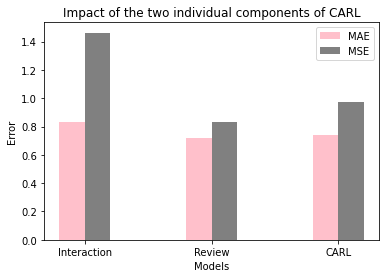

In [ ]:
mae_list = [0.8343969736732412, 0.7217927465114119, 0.7376690645403283]
mse_list = [1.4630443995149833, 0.8296060701243427, 0.9709354154188156]
models = ['Interaction','Review', 'CARL']
X_axis = np.arange(len(models))
plt.bar(X_axis - 0.1, mae_list, 0.2, label = 'MAE', color='pink')
plt.bar(X_axis + 0.1, mse_list, 0.2, label = 'MSE', color='grey')
plt.title('Impact of the two individual components of CARL')
plt.xticks(X_axis, models)
plt.xlabel('Models')
plt.ylabel('Error')
plt.legend()
plt.show()